# Table of Contents

1. [Business Understanding](#Business-Understanding)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Model Building](#Model-Building)
5. [Productivization Plan](#Productivization-Plan)
6. [Next steps](#Next-steps)

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, make_scorer

from fancyimpute import KNN

import joblib
import pickle

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Given a set of features, we are asked to <b>predict whether or not a given household is poor or not</b>. This is a binary classification, which specifically posits the following problem: what is the <b>probability</b> of a given household of being poor. This probability is actually the prediction value and the loss function measures the prediction performance. For a binary classification, the typical loss function is the binary cross-entropy or <b>log loss</b>.<br>

Log Loss is a slight twist on the Likelihood Function. In fact, Log Loss is -1 * the log of the likelihood function. The likelihood function answers the question "How likely did the model think the actually observed set of outcomes was" and is computed iteratively stepping through all predictions by multiplying the probability associated with the actual outcome and subsequently by the previous result.<br>

Predictions ranging between 0 and 1, if you multiply enough numbers in this range, the result gets so small that computers can't keep track of it. So, as a clever computational trick, we instead keep track of the log of the Likelihood. We multiply this by negative 1 to maintain a common convention that lower loss scores are better. Lower loss scores are associated with higher probabilities and viceversa<br>

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Load Data

In [2]:
# Train dataset
data_train = pd.read_csv('../data/Exercise_train (1).csv', sep=',')
data_train.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2225,29252,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
1,1598,98286,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
2,7896,49040,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
3,1458,35261,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
4,1817,98833,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


In [3]:
# Test dataset
data_test = pd.read_csv('../data/Exercise_test (1).csv', sep=',')
data_test.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2197,42706,qzGkS,zPfZR,rXCdD,IJnCs,21.0,-3.0,-5.0,-9.5,False
1,4823,65531,KfoTG,THHLT,DtMvg,XHmQd,21.0,-2.0,-9.0,-19.5,True
2,4165,64452,tnDpM,THHLT,qTmDg,yygvO,30.0,-4.0,-9.0,-19.5,True
3,4962,78022,NaN,WXYiE,DtMvg,XAmOF,21.0,-2.0,3.0,10.5,False
4,4671,45674,Lsuai,zPfZR,DtMvg,hmAUm,30.0,-4.0,-5.0,-9.5,True


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6562 entries, 0 to 6561
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6562 non-null   int64  
 1   id          6562 non-null   int64  
 2   kjkrfgld    6366 non-null   object 
 3   bpowgknt    6357 non-null   object 
 4   raksnhjf    6381 non-null   object 
 5   vwpsxrgk    6364 non-null   object 
 6   omtioxzz    6361 non-null   float64
 7   yfmzwkru    6353 non-null   float64
 8   tiwrsloh    6355 non-null   float64
 9   weioazcf    6366 non-null   float64
 10  poor        6562 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 519.2+ KB


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1641 non-null   int64  
 1   id          1641 non-null   int64  
 2   kjkrfgld    1595 non-null   object 
 3   bpowgknt    1592 non-null   object 
 4   raksnhjf    1605 non-null   object 
 5   vwpsxrgk    1596 non-null   object 
 6   omtioxzz    1587 non-null   float64
 7   yfmzwkru    1597 non-null   float64
 8   tiwrsloh    1601 non-null   float64
 9   weioazcf    1579 non-null   float64
 10  poor        1641 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 129.9+ KB


In both datasets, we encounter:
<ul>
    <li> same number of non-null values in the Unnamed: 0 column (supposedly, individuals <code>iid</code>) and households <code>id</code>, so that individuals analysis becomes irrelevant</li>
    <li> four possible categorical (nominal) variables represented as object (strings) with missing values both in train and in test(around 3% of each dataset)</li>
    <li> four continuous variables represented as float, with missing values both in train and in test(around 3% of each dataset)</li>
    <li> target variable represented as a boolean</li>
</ul>

#### No duplicates / Unique observations

In [17]:
column_names = [x for x in data_train.columns]
duplicates = data_train.duplicated(subset=column_names, keep=False)
data_train[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [7]:
data_train.id.nunique() 

6562

In [9]:
column_names = [x for x in data_test.columns]
duplicates = data_test.duplicated(subset=column_names, keep=False)
data_test[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [8]:
data_test.id.nunique()

1641

In [4]:
data_train = data_train.set_index('id')
data_test = data_test.set_index('id')

## Target

<AxesSubplot:title={'center':'Number of Poor'}>

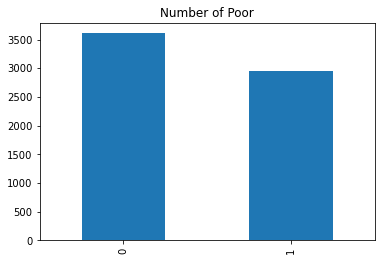

In [150]:
data_train.poor.value_counts().plot.bar(title='Number of Poor')

<AxesSubplot:title={'center':'Number of Poor'}>

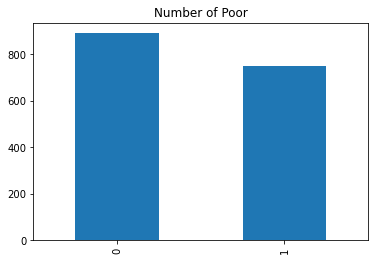

In [151]:
data_test.poor.value_counts().plot.bar(title='Number of Poor')

## Numerical features

In [26]:
data_train.describe()

,Unnamed: 0,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,6562.000000,6361.000000,6353.000000,6355.000000,6366.000000
mean,4113.757543,17.455117,-2.826696,-4.194335,-7.461828
std,2353.382080,10.924393,12.615775,4.476410,11.198626
min,0.000000,-127.000000,-4.000000,-31.000000,-74.500000
25%,2088.500000,12.000000,-4.000000,-7.000000,-14.500000
50%,4115.500000,12.000000,-3.000000,-3.000000,-4.500000
75%,6156.750000,21.000000,-2.000000,-1.000000,0.500000
max,8202.000000,111.000000,1000.000000,3.000000,10.500000


Descriptive statistics of the four numerical variables uncover the following:
<ul>
    <li>there are missing values</li>
    <li>skewed distributions and presence of outliers</li>
</ul>

## Categorical features

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


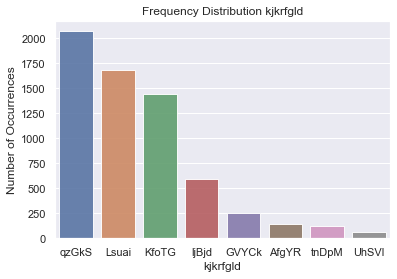

In [15]:
kjkrfgld_count = cat_data_train['kjkrfgld'].value_counts()
sns.set(style="darkgrid")
sns.barplot(kjkrfgld_count.index, kjkrfgld_count.values, alpha=0.9)
plt.title('Frequency Distribution kjkrfgld')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('kjkrfgld', fontsize=12)
plt.show()

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


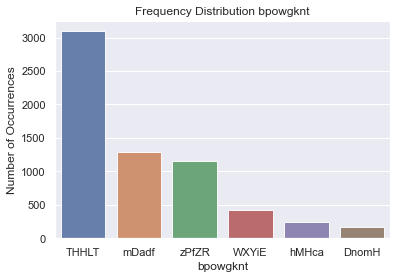

In [62]:
bpowgknt_count = cat_data_train['bpowgknt'].value_counts()
sns.set(style="darkgrid")
sns.barplot(bpowgknt_count.index, bpowgknt_count.values, alpha=0.9)
plt.title('Frequency Distribution bpowgknt')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bpowgknt', fontsize=12)
plt.show()

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


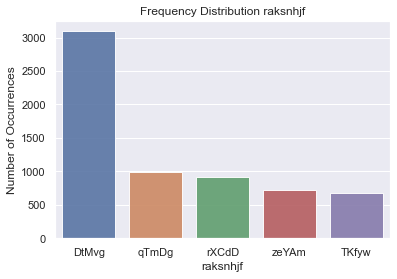

In [64]:
raksnhjf_count = cat_data_train['raksnhjf'].value_counts()
sns.set(style="darkgrid")
sns.barplot(raksnhjf_count.index, raksnhjf_count.values, alpha=0.9)
plt.title('Frequency Distribution raksnhjf')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('raksnhjf', fontsize=12)
plt.show()

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


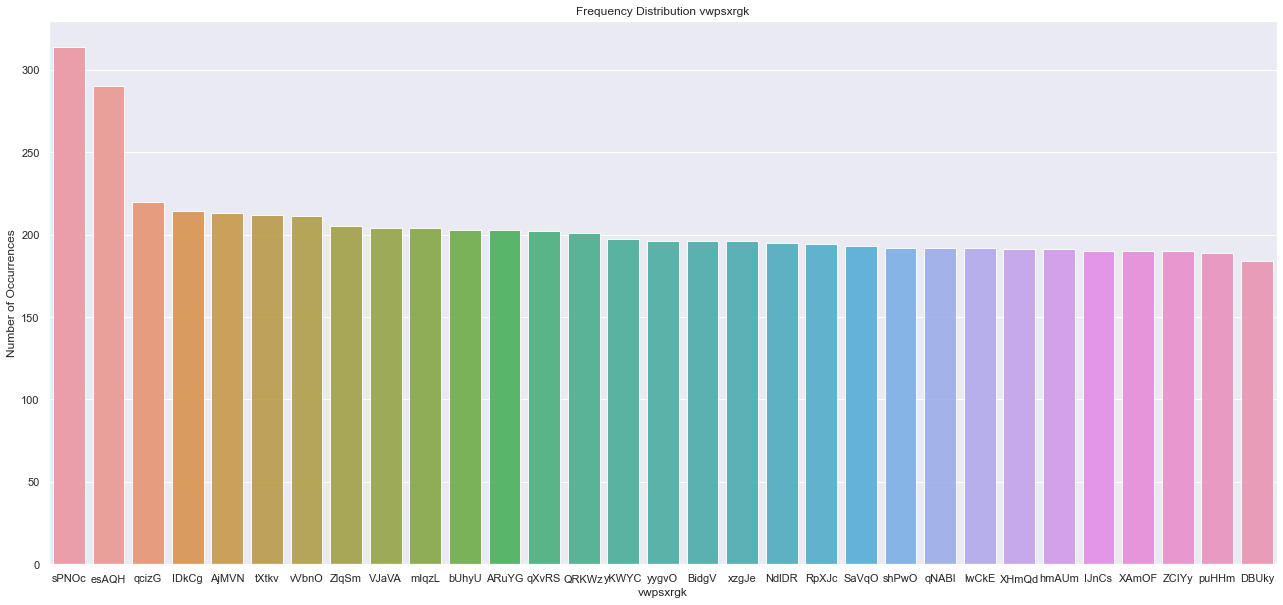

In [68]:
vwpsxrgk_count = cat_data_train['vwpsxrgk'].value_counts()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(22,10)})
sns.barplot(vwpsxrgk_count.index, vwpsxrgk_count.values, alpha=0.9)
plt.title('Frequency Distribution vwpsxrgk')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('vwpsxrgk', fontsize=12)
plt.show()

# Data Preprocessing
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Binary target variable

Let's transform our target variable into a binary (0, 1) variable.

In [5]:
data_train['poor'] = data_train['poor'].apply(lambda x: 1 if x == True else 0)

In [6]:
data_test['poor'] = data_test['poor'].apply(lambda x: 1 if x == True else 0)

## Numerical features

Two-step approach:
<ol>
    <li> adopt an <b>imputation</b> method for missing values based on the distribution's median,</li>
    <li> <b>standardize</b> data to avoid degradation of the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators.<br>
        We first use PowerTransformer method since it accounts for skewed distributions (and outliers?). However, we shall perform other methods and visualize plots in order to make the most accurate data standardization.</li>
</ul>
    
[Documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [7]:
def num_proc(data):
    # Numerical features
    data = data.drop('Unnamed: 0', axis=1)
    num_data = data.select_dtypes(include=['float64']).copy()
    
    # Imputation
    median_imputer = SimpleImputer(strategy='median')
    num_data.iloc[:,:] = median_imputer.fit_transform(num_data)
    
    # Standardization
    scaler = PowerTransformer()
    num_data.iloc[:, 0:4] = scaler.fit_transform(num_data)
    
    return num_data

### Train data

In [8]:
num_data_train = num_proc(data_train)
num_data_train.head()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
id,,,,
29252,-0.480203,0.102811,0.638589,0.628295
98286,0.350762,1.159184,-0.279685,-0.280701
49040,-0.480203,0.102811,-0.279685,-0.280701
35261,-0.480203,1.907488,-0.279685,-0.280701
98833,0.350762,-1.263886,-0.279685,-0.280701


In [9]:
print(num_data_train.isnull().values.sum())

0


In [60]:
num_data_train.describe()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,6.562000e+03,6.562000e+03,6.562000e+03,6.562000e+03
mean,-6.496886e-18,-5.100055e-16,1.461799e-17,1.375174e-16
std,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00
min,-1.607661e+01,-1.263886e+00,-4.726749e+00,-4.873746e+00
25%,-4.802031e-01,-1.263886e+00,-6.870227e-01,-6.811696e-01
50%,-4.802031e-01,1.028108e-01,1.557923e-01,1.438061e-01
75%,3.507622e-01,1.159184e+00,6.385893e-01,6.282954e-01
max,8.342011e+00,4.207054e+00,1.974409e+00,1.957637e+00


### Test data

In [10]:
num_data_test = num_proc(data_test)
num_data_test.head()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
id,,,,
42706,0.404017,0.101349,-0.278625,-0.278740
65531,0.404017,1.177563,-1.074606,-1.071908
64452,1.174058,-1.248141,-1.074606,-1.071908
78022,0.404017,1.177563,1.970861,1.973978
45674,1.174058,-1.248141,-0.278625,-0.278740


In [12]:
print(num_data_test.isnull().values.sum())

0


In [11]:
num_data_test.describe()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,1.641000e+03,1.641000e+03,1.641000e+03,1.641000e+03
mean,-9.742359e-18,6.278409e-16,-1.380168e-17,-2.381466e-17
std,1.000305e+00,1.000305e+00,1.000305e+00,1.000305e+00
min,-3.328899e+00,-1.248141e+00,-3.491585e+00,-3.579589e+00
25%,-4.428214e-01,-1.248141e+00,-6.863999e-01,-6.829049e-01
50%,-4.428214e-01,1.013492e-01,1.570566e-01,1.494899e-01
75%,4.040173e-01,1.177563e+00,6.396304e-01,6.377120e-01
max,4.485813e+00,2.724022e+00,1.970861e+00,1.973978e+00


## Categorical features

Typically, any standard work-flow in feature engineering involves some form of transformation of these categorical values into numeric labels and then applying some encoding scheme on these values.<br>

The lack of context information difficults the decision on the encoding scheme. But, we will lately come back to this issue.

Categorical values also need NAs imputation, similarly to numerical values.<br>

As categorical values are strings and we cannot perform operations on strings, we have the necessity to convert/encode strings to numeric values and impute NAs.<br>

As suggested by this [DataCamp course](https://learn.datacamp.com/courses/dealing-with-missing-data-in-python), we may follow this three step-approach:<br>
<ol>
    <li>Convert non-missing categorical columns to ordinal values</li>
    <li>Impute the missing values in the ordinal DataFrame</li>
    <li>Convert back from ordinal values to categorical values</li>
</ol>

In [13]:
def cat_proc(data):
    # Select object types
    cat_data = data.select_dtypes(include=['object']).copy()
    
    # NAs imputation
    # Ordinal Encoding of cat_data_train DataFrame
    ordinal_enc_dict = {}

    for col_name in cat_data:
        # Create an Ordinal Encoder for col
        ordinal_enc_dict[col_name] = OrdinalEncoder()
        col = cat_data[col_name]
    
        # Select non-null values of columns (Ordinal Encoder does not work with NAs)
        col_not_null = col[col.notnull()]
        reshaped_vals = col_not_null.values.reshape(-1, 1)
        encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
        # Store the values to non-null values of the column in data
        cat_data.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)
        
        
    # Create KNN imputer
    KNN_imputer = KNN()

    # Impute and round the users DataFrame
    cat_data.iloc[:, :] = np.round(KNN_imputer.fit_transform(cat_data))
    
    # Loop over the columns
    for col_name in cat_data:
    
        # Reshape the data
        reshaped = cat_data[col_name].values.reshape(-1, 1)
    
        # Perform inverse transform of the ordinally encoded columns
        cat_data[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)
        
    return cat_data      

### Train data

In [14]:
cat_data_train = cat_proc(data_train)
cat_data_train.head()

Imputing row 1/6562 with 1 missing, elapsed time: 3.496
Imputing row 101/6562 with 0 missing, elapsed time: 3.506
Imputing row 201/6562 with 0 missing, elapsed time: 3.507
Imputing row 301/6562 with 0 missing, elapsed time: 3.507
Imputing row 401/6562 with 0 missing, elapsed time: 3.508
Imputing row 501/6562 with 0 missing, elapsed time: 3.509
Imputing row 601/6562 with 0 missing, elapsed time: 3.509
Imputing row 701/6562 with 0 missing, elapsed time: 3.510
Imputing row 801/6562 with 0 missing, elapsed time: 3.510
Imputing row 901/6562 with 0 missing, elapsed time: 3.511
Imputing row 1001/6562 with 0 missing, elapsed time: 3.511
Imputing row 1101/6562 with 0 missing, elapsed time: 3.512
Imputing row 1201/6562 with 0 missing, elapsed time: 3.512
Imputing row 1301/6562 with 1 missing, elapsed time: 3.513
Imputing row 1401/6562 with 1 missing, elapsed time: 3.513
Imputing row 1501/6562 with 1 missing, elapsed time: 3.514
Imputing row 1601/6562 with 0 missing, elapsed time: 3.514
Imputing 

,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk
id,,,,
29252,KfoTG,zPfZR,DtMvg,ZCIYy
98286,ljBjd,THHLT,DtMvg,esAQH
49040,Lsuai,zPfZR,zeYAm,ZCIYy
35261,KfoTG,mDadf,zeYAm,ZCIYy
98833,KfoTG,THHLT,DtMvg,ARuYG


In [15]:
print(cat_data_train.isnull().values.sum())

0


### Test data

In [16]:
cat_data_test = cat_proc(data_test)
cat_data_test.head()

Imputing row 1/1641 with 0 missing, elapsed time: 0.245
Imputing row 101/1641 with 0 missing, elapsed time: 0.246
Imputing row 201/1641 with 0 missing, elapsed time: 0.246
Imputing row 301/1641 with 0 missing, elapsed time: 0.247
Imputing row 401/1641 with 0 missing, elapsed time: 0.247
Imputing row 501/1641 with 0 missing, elapsed time: 0.247
Imputing row 601/1641 with 0 missing, elapsed time: 0.248
Imputing row 701/1641 with 1 missing, elapsed time: 0.248
Imputing row 801/1641 with 1 missing, elapsed time: 0.249
Imputing row 901/1641 with 0 missing, elapsed time: 0.249
Imputing row 1001/1641 with 0 missing, elapsed time: 0.249
Imputing row 1101/1641 with 0 missing, elapsed time: 0.250
Imputing row 1201/1641 with 0 missing, elapsed time: 0.250
Imputing row 1301/1641 with 0 missing, elapsed time: 0.251
Imputing row 1401/1641 with 1 missing, elapsed time: 0.251
Imputing row 1501/1641 with 0 missing, elapsed time: 0.252
Imputing row 1601/1641 with 0 missing, elapsed time: 0.252


,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk
id,,,,
42706,qzGkS,zPfZR,rXCdD,IJnCs
65531,KfoTG,THHLT,DtMvg,XHmQd
64452,tnDpM,THHLT,qTmDg,yygvO
78022,Lsuai,WXYiE,DtMvg,XAmOF
45674,Lsuai,zPfZR,DtMvg,hmAUm


In [17]:
print(cat_data_test.isnull().values.sum())

0


In [19]:
# cat_data_train = cat_data_train.astype('category')
cat_data_train.dtypes

kjkrfgld    object
bpowgknt    object
raksnhjf    object
vwpsxrgk    object
dtype: object

In [65]:
# Label Encoder
# cat_data_train = cat_data_train.apply(lambda col: cat_data_train[col].cat.codes, axis=1)
# cat_data_train.head()

## Features and targets

In [18]:
train = pd.concat([num_data_train, cat_data_train], axis=1)
train = train.join(data_train['poor'])

In [19]:
test = pd.concat([num_data_test, cat_data_test], axis=1)
test = test.join(data_test['poor'])

In [20]:
train.head()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,poor
id,,,,,,,,,
29252,-0.480203,0.102811,0.638589,0.628295,KfoTG,zPfZR,DtMvg,ZCIYy,0
98286,0.350762,1.159184,-0.279685,-0.280701,ljBjd,THHLT,DtMvg,esAQH,1
49040,-0.480203,0.102811,-0.279685,-0.280701,Lsuai,zPfZR,zeYAm,ZCIYy,1
35261,-0.480203,1.907488,-0.279685,-0.280701,KfoTG,mDadf,zeYAm,ZCIYy,0
98833,0.350762,-1.263886,-0.279685,-0.280701,KfoTG,THHLT,DtMvg,ARuYG,1


In [21]:
test.head()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,poor
id,,,,,,,,,
42706,0.404017,0.101349,-0.278625,-0.278740,qzGkS,zPfZR,rXCdD,IJnCs,0
65531,0.404017,1.177563,-1.074606,-1.071908,KfoTG,THHLT,DtMvg,XHmQd,1
64452,1.174058,-1.248141,-1.074606,-1.071908,tnDpM,THHLT,qTmDg,yygvO,1
78022,0.404017,1.177563,1.970861,1.973978,Lsuai,WXYiE,DtMvg,XAmOF,0
45674,1.174058,-1.248141,-0.278625,-0.278740,Lsuai,zPfZR,DtMvg,hmAUm,1


In [22]:
y_train = train.iloc[:, -1]

In [23]:
X_train = train.iloc[:, 0:-1]

In [24]:
y_test = test.iloc[:, -1]

In [25]:
X_test = test.iloc[:, 0:-1]

# Model Building
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Create Pipeline

So far, we have imputed NAs in numerical and categorical values and scaled numerical values in a step-by-step approach. Alternatively, this data preprocessing could have been embedded in a data pipeline. To be noted that Ordinal Encoder (category_encoders) in a pipeline would have resolved both NA imputation and ordinal categorical encoding. In the previous section, we used <i>out-of-the-pipe</i> scikit-learn's Ordinal Encoder to convert non-missing categorical columns to ordinal values only before imputing NAs (and ultimately converting categories back to strings).<br>

However, there is a data preprocessing's last step, namely categorical feature encoding that, for a matter of simplicity, will be tackled with a column transform and plugged into a model pipeline.<br>

We will opt for an ordinal encoder for those variables with a low dimensionality (and coincidentally, uneven frequency distribution among categories) and for a target encoder for the variable with a greater dimensionality. With target encoding, each category is replaced with the mean target value for samples having that category. This prevents increasing the dimensionality of our data but it also captures correlations in target values, which is precisely the source of overfitting. This should be carefully addressed; as such, we will train sigma variable of target encoder (or the noise). 

Check for reference this [video](https://www.youtube.com/watch?v=Ma-CDFLd03g) (minute 58 onwards) and this [tutorial](https://www.datacamp.com/community/tutorials/categorical-data). For more information on target encoding, read this [post](https://brendanhasz.github.io/2019/03/04/target-encoding).<br>

We shall start with a <b>Logistic Regression</b> and <b>Random Forest Classifier</b> as our baseline.

In [29]:
# Recall that in this step, we will be using Ordinal Encoder from category_encoders
from category_encoders import OrdinalEncoder, LeaveOneOutEncoder

In [83]:
ordinal_enc = OrdinalEncoder()
target_enc = LeaveOneOutEncoder()

column_trans = ColumnTransformer(
                   [('ordinal_encoder', ordinal_enc, ['kjkrfgld', 'bpowgknt', 'raksnhjf']),
                   ('target_encoder', target_enc, ['vwpsxrgk'])
                   # remainder='passthrough'
    ])

In [82]:
clf = LogisticRegression()
pipe = Pipeline([('column_transform', column_trans), ('classifier', clf)])

pipe.fit(X_train, y_train)
pipe.predict(X_test)

y_pred = rscv.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

1.0609683398231704

In [84]:
clf = RandomForestClassifier()
pipe = Pipeline([('column_transform', column_trans), ('classifier', clf)])

### Train

In [85]:
# Hyperparameters can be accessed with a double underscore
param_grid = {
    'column_transform__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'classifier__bootstrap': [True],
    'classifier__max_depth': [80, 90, 100, 110],
    'classifier__max_features': [2, 3],
    'classifier__min_samples_leaf': [3, 4, 5],
#     'classifier_min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300, 1000]
}

rscv = RandomizedSearchCV(pipe,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)


rscv.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('column_transform',
                                              ColumnTransformer(transformers=[('ordinal_encoder',
                                                                               OrdinalEncoder(),
                                                                               ['kjkrfgld',
                                                                                'bpowgknt',
                                                                                'raksnhjf']),
                                                                              ('target_encoder',
                                                                               LeaveOneOutEncoder(),
                                                                               ['vwpsxrgk'])])),
                                             ('classifier',
                                              RandomForestClassifier())]),
      

In [86]:
rscv.best_params_

{'column_transform__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 300,
 'classifier__min_samples_leaf': 4,
 'classifier__max_features': 2,
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [87]:
rscv.best_score_

-0.6434269455402452

### Test

Metrics [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss)

In [88]:
y_pred = rscv.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.6397872577306624

Both train and test metrics are similar, so we could infer that the model has not committed apparent overfitting... Nonetheless, we have to lower the log loss for a better predicted probability.<br>

Next steps,
<ul>
    <li>build additional models (catboost, lightboost, xgb, nn) and loop over them</li>
    <li>compare log-loss metrics and others, such as confusion matrix, roc_auc, accuracy and f1 score</li>
</ul>

## Boosting methods

[Read](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/) on methods' differences.

In [39]:
classifier = {'CB': CatBoostClassifier(), 'LGB': LGBMClassifier(), 'XGB': XGBClassifier()}
results = pd.DataFrame()

for key, value in classifier.items():
    # Define pipeline
    pipe = Pipeline([('column_transform', column_trans), ('classifier', value)
                     
    # Hyperparameter tunning
                     
                     
    # RandomizedSearchCV
    rscv = RandomizedSearchCV(pipe,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)
                     
    # Fit the model
    rscv.fit(X_train, y_train)
                     
    # Best parameters and scoring
    rscv.best_params_
    rscv.best_score_
                     
    # Predict
    y_pred = rscv.best_estimator_.predict_proba(X_test)
    log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    results[key].append(y_pred)

results_final = pd.concat(data_train.index, results)
    

SyntaxError: invalid syntax (<ipython-input-39-c2589b93afb3>, line 12)

### CatBoost

In [89]:
clf = CatBoostClassifier()
pipe = Pipeline([('column_transform', column_trans), ('classifier', clf)])

Hyperparameters tunning [Documentation](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

In [93]:
# Hyperparameters can be accessed with a double underscore
param_grid_CB = {
        'column_transform__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
        'classifier__loss_function' : 'Logloss',
        'classifier__logging_level' : 'Silent',
}

rscv = RandomizedSearchCV(pipe,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)

In [94]:
rscv.fit(X_train, y_train)

TypeError: __init__() got an unexpected keyword argument 'min_samples_leaf'

In [67]:
rscv.best_params_

{'column_transform__target_encoder__sigma': 0.01,
 'classifier__n_estimators': 100,
 'classifier__min_samples_leaf': 3,
 'classifier__max_features': 3,
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [68]:
rscv.best_score_

-1.049902458858454

In [69]:
y_pred = rscv.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

1.1082566304657915

### Light Gradient Boosting

[Hyperparameter tunning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [95]:
clf = LGBMClassifier()
pipe = Pipeline([('column_transform', column_trans), ('classifier', clf)])

In [96]:
# Hyperparameters can be accessed with a double underscore
param_grid_LGBM = {
        'column_transform__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
        'classifier__loss_function' : 'Logloss',
        'classifier__silent' : True,
        'classifier__boosting_type' : 'gbdt',
        'classifier__objective' : 'binary',
        'classifier__gamma' : 0.3,
        'classifier__subsample' : 0.6,
        'classifier__reg_alpha' : 0.02,
        'classifier__is_unbalance' : True,
        'classifier__reg_lambda' : 0.01,
}

rscv = RandomizedSearchCV(pipe,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)

In [97]:
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('column_transform',
                                              ColumnTransformer(transformers=[('ordinal_encoder',
                                                                               OrdinalEncoder(),
                                                                               ['kjkrfgld',
                                                                                'bpowgknt',
                                                                                'raksnhjf']),
                                                                              ('target_encoder',
                                                                               LeaveOneOutEncoder(),
                                                                               ['vwpsxrgk'])])),
                                             ('classifier', LGBMClassifier())]),
                   n_iter=5, n_jobs=10,
                   p

In [98]:
rscv.best_params_

{'column_transform__target_encoder__sigma': 0.04,
 'classifier__n_estimators': 200,
 'classifier__min_samples_leaf': 5,
 'classifier__max_features': 3,
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [99]:
rscv.best_score_

-0.6581906227844617

In [100]:
y_pred = rscv.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.642762653901469

### Extreme Gradient Boosting

In [101]:
clf = XGBClassifier()
pipe = Pipeline([('column_transform', column_trans), ('classifier', clf)])

In [102]:
# Hyperparameters can be accessed with a double underscore
param_grid_CB = {
        'column_transform__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [3, 4, 5],
        'classifier__objective' : 'binary:logistic',
        'classifier__silent' : True,
        'classifier__gamma' : 0.3,
        'classifier__subsample' : 0.7,
        'classifier__reg_alpha' : 0.05
}

rscv = RandomizedSearchCV(pipe,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)

In [103]:
rscv.fit(X_train, y_train)

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:48:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:48:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('column_transform',
                                              ColumnTransformer(transformers=[('ordinal_encoder',
                                                                               OrdinalEncoder(),
                                                                               ['kjkrfgld',
                                                                                'bpowgknt',
                                                                                'raksnhjf']),
                                                                              ('target_encoder',
                                                                               LeaveOneOutEncoder(),
                                                                               ['vwpsxrgk'])])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
    

In [104]:
rscv.best_params_

{'column_transform__target_encoder__sigma': 0.01,
 'classifier__n_estimators': 100,
 'classifier__min_samples_leaf': 3,
 'classifier__max_features': 3,
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [105]:
rscv.best_score_

-1.0080221850750244

In [106]:
y_pred = rscv.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.9698355597690081

## A Neural Network model for binary classification

Check this DataCamp [course](https://learn.datacamp.com/courses/deep-learning-with-keras-in-python) for more information.<br>
Debug Attribute error with the following [GitHub issue](https://github.com/tensorflow/tensorflow/issues/38589).

In [119]:
# Function that creates a Keras model
def create_model(optimizer='sgd', activation='tanh'):
    model = Sequential()
    model.add(Dense(4, input_shape=(2,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model
    
# Create a model a sklearn estimator
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16)
    
# Plug the model into the pipeline
pipe = Pipeline([('column_transform', column_trans), ('classifier', model)])
    
# Random search on a Keras model
params = dict(optimizer=['sgd', 'adam'], epochs=3,
              batch_size=[5, 10, 20], activation=['tanh', 'LeakyReLU']
              
rscv_nn = RandomizedSearchCV(pipe, params_dist=params, cv=3)
              
rscv_nn.fit(X_train, y_train)
              
rscv_nn.best_scores_
rscv_nn.best_params_
              

SyntaxError: invalid syntax (<ipython-input-119-252077236823>, line 19)

In [ ]:
preds = model.predict(X_test)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {}, Test loss: {}'.format(test_acc, test_loss))

## Ensembling Models

DataCamp [Webinar](https://www.datacamp.com/resources/webinars/applied-machine-learning-stacking-ensemble-models?utm_medium=email&utm_source=customerio&utm_campaign=livetraining&utm_id=3679156): Applied Machine Learning - Stacking Ensemble Models

In [ ]:
results = pd.DataFrame({
    'predicted': y_pred
}).set_index('id').\
to_csv('../model/results.csv')

# Productivization Plan
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

After building a model in lab conditions, we shall export a copy of it to the production server, where new data will be labelled. This process is called model deployment or pushing to production. To enable this, we shall serialize our model, that is, convert it to a binary file with pickle.<br>

Ideally, we should encapsulate the whole process into a single object (pipeline) to interact with production otherwise, we will have to repeat one or various processes in production. We shall aim at avoiding bugs eventually causing financial problems.

<b>Figure 1</b>: <b>Model Deployment</b> (<i>source: DataCamp</i>)<br>
<img src="../images/model_deployment.png">

In [ ]:
joblib.dump(rscv.best_estimator_, 'model/trained_pipeline.pkl')

Save pickle file in write mode.

In [ ]:
with open('../model/model.pkl', 'wb') as file:
    pickle.dump(rscv.best_estimator_, file=file)

Load pickle file in read mode.

In [ ]:
with open('../model/model.pkl', 'rb') as file:
    clf2 = pickle.load(file)

# Next steps
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Building on the previous idea,
<ul>
    <li>Build a robust pipeline</li>
    <li>Feature importances assessment and feature extraction</li>
    
</ul>

Check this Stackoverflow [post](https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer) and [Datacamp course](https://learn.datacamp.com/courses/designing-machine-learning-workflows-in-python)